In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [16]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [17]:
fracs_mnum = 1080
seeds_mnum = 108

In [18]:
both_res = parse_results('grid_search_results/subsets_both_5-seeds_100.txt')
frac1 = both_res[fracs_mnum*0:fracs_mnum*1]
frac2 = both_res[fracs_mnum*1:fracs_mnum*2]
frac3 = both_res[fracs_mnum*2:fracs_mnum*3]
frac4 = both_res[fracs_mnum*3:fracs_mnum*4]
frac6 = both_res[fracs_mnum*4:fracs_mnum*5]
frac8 = both_res[fracs_mnum*5:fracs_mnum*6]
# hyp_res = both_res[:len(both_res)//2]
# euc_res = both_res[len(both_res)//2:]
# hyp_res = both_res
# euc_res = both_res
frac = frac8
hyp_res = frac
euc_res = frac

In [19]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

# fix for fracs with multiple seeds
hyp_params = hyp_params[[i for i in list(range(fracs_mnum)) if not (i//seeds_mnum)%2]]
hyp_values = hyp_values[[i for i in list(range(fracs_mnum)) if not (i//seeds_mnum)%2]]

euc_params = euc_params[[i for i in list(range(fracs_mnum)) if (i//seeds_mnum)%2]]
euc_values = euc_values[[i for i in list(range(fracs_mnum)) if (i//seeds_mnum)%2]]

hyp_values.shape, euc_values.shape

((540, 3, 100), (540, 3, 100))

In [20]:
hyp_params = hyp_params.reshape([5,seeds_mnum])[0]
hyp_values = hyp_values.reshape([5,seeds_mnum,3,100]).mean(axis=0)

euc_params = euc_params.reshape([5,seeds_mnum])[0]
euc_values = euc_values.reshape([5,seeds_mnum,3,100]).mean(axis=0)

hyp_values.shape, euc_values.shape

((108, 3, 100), (108, 3, 100))

In [21]:
NUM_HIDDEN_LAYERS = sorted(list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params]))))
LAYER_SIZE = sorted(list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params]))))
LR = sorted(list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params]))))
WD = sorted(list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params]))))

In [22]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)

[4, 8, 16]
[2, 8, 16, 64]
[0.01, 0.02, 0.04]
[0.003, 0.004, 0.005]


In [23]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

In [24]:
num_hidden_layers, layer_size

(array([ 4,  4,  4,  4,  8,  8,  8,  8, 16, 16, 16, 16]),
 array([ 2,  8, 16, 64,  2,  8, 16, 64,  2,  8, 16, 64]))

--------------- Weight Decay: 0.003 ---------------


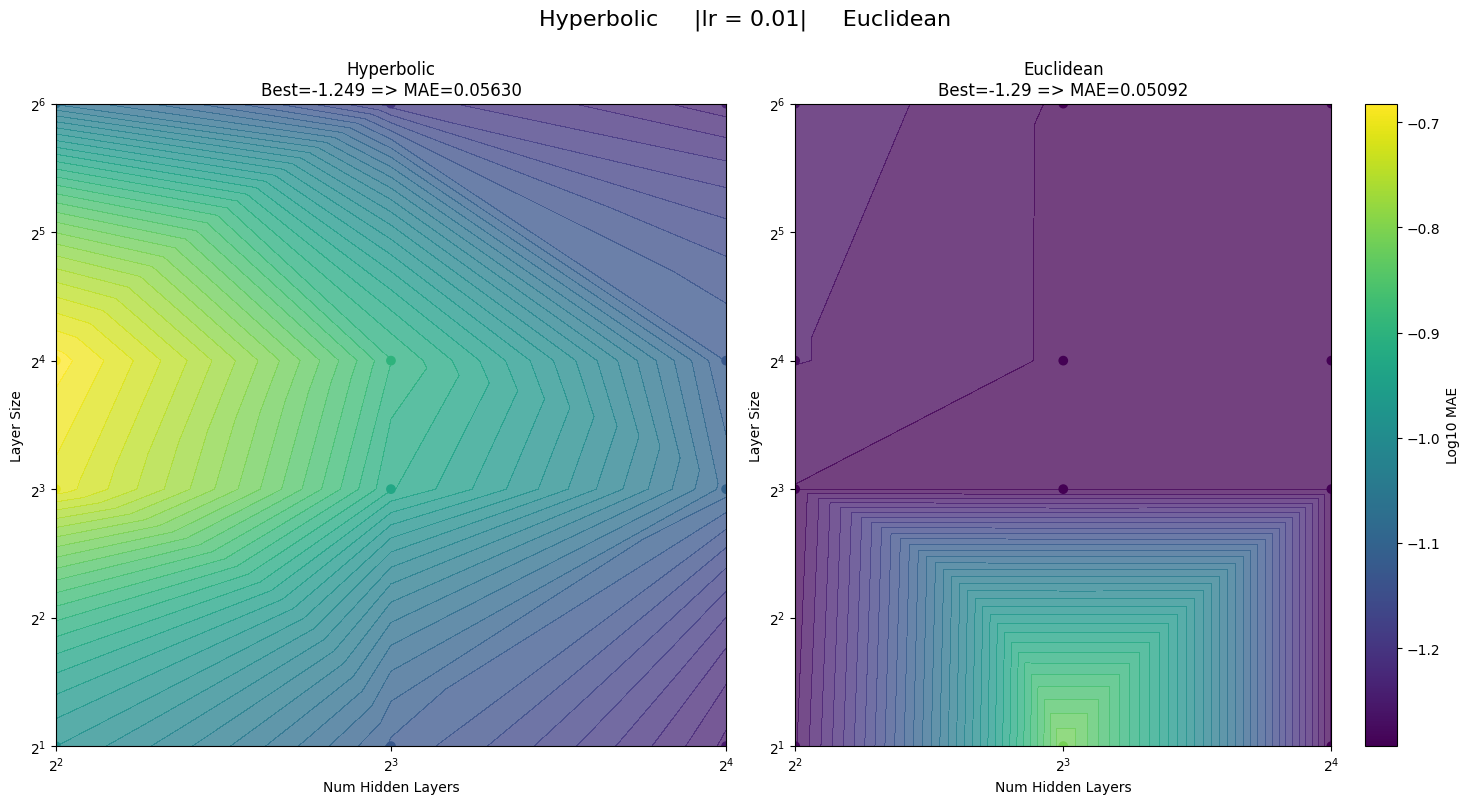

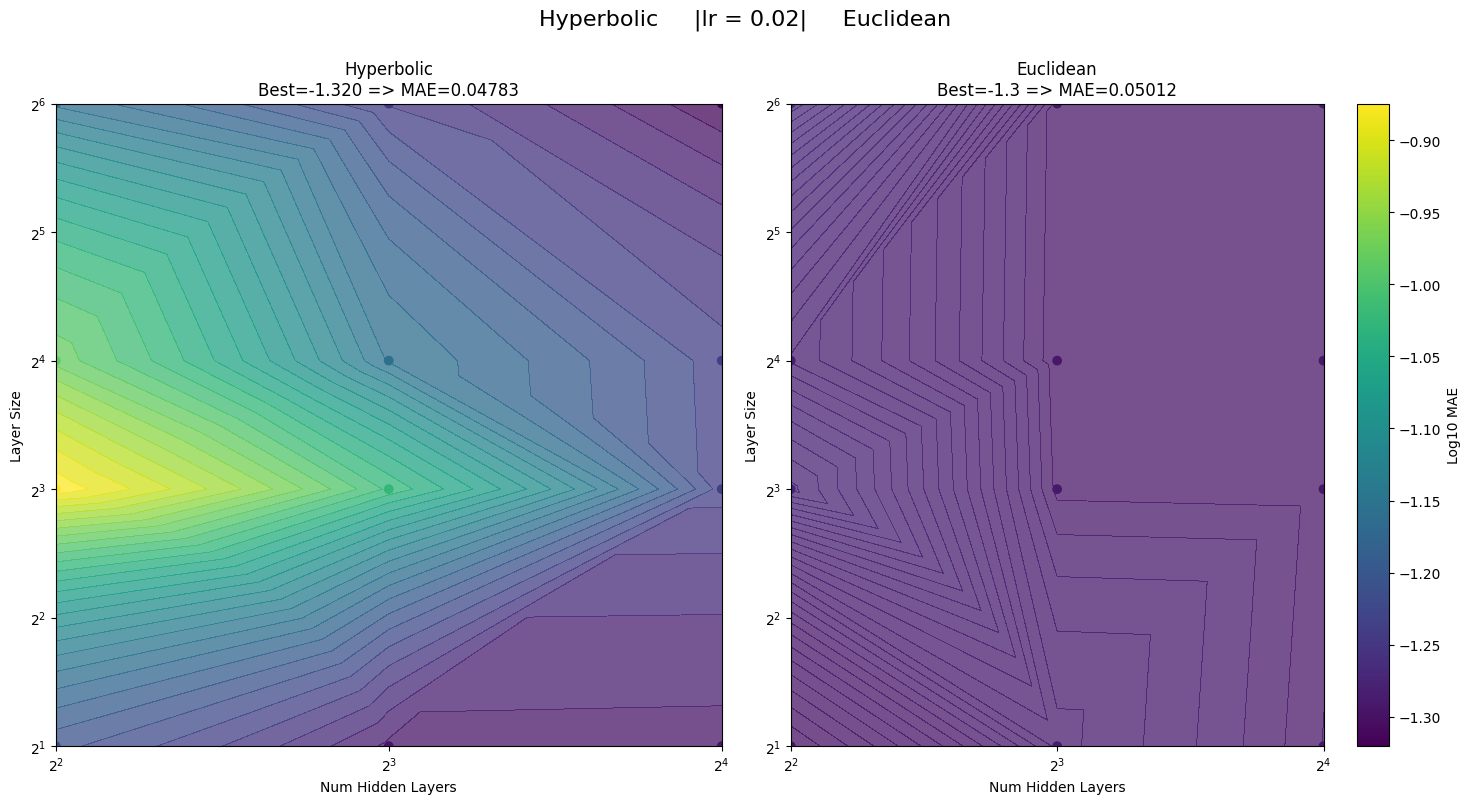

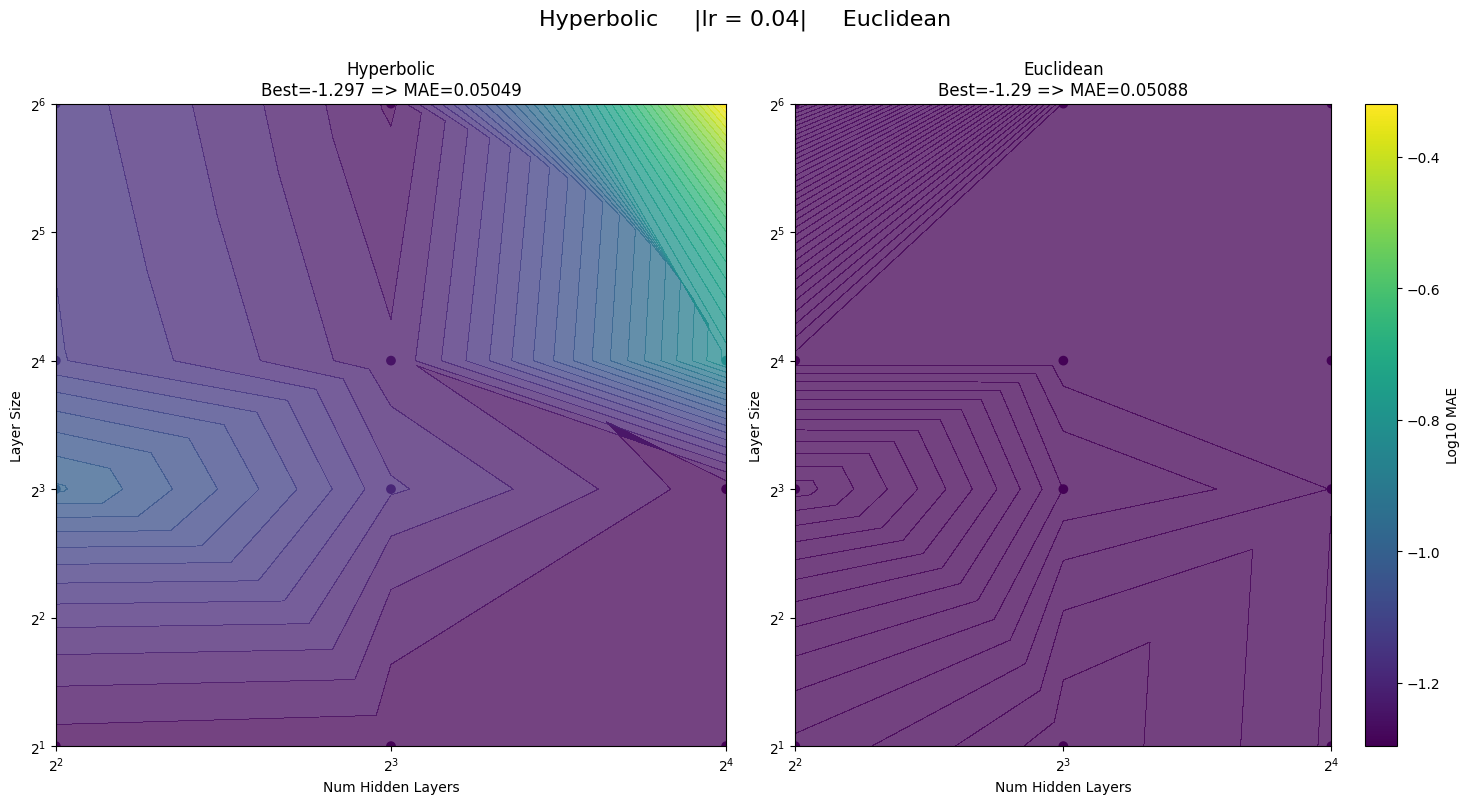

--------------- Weight Decay: 0.004 ---------------


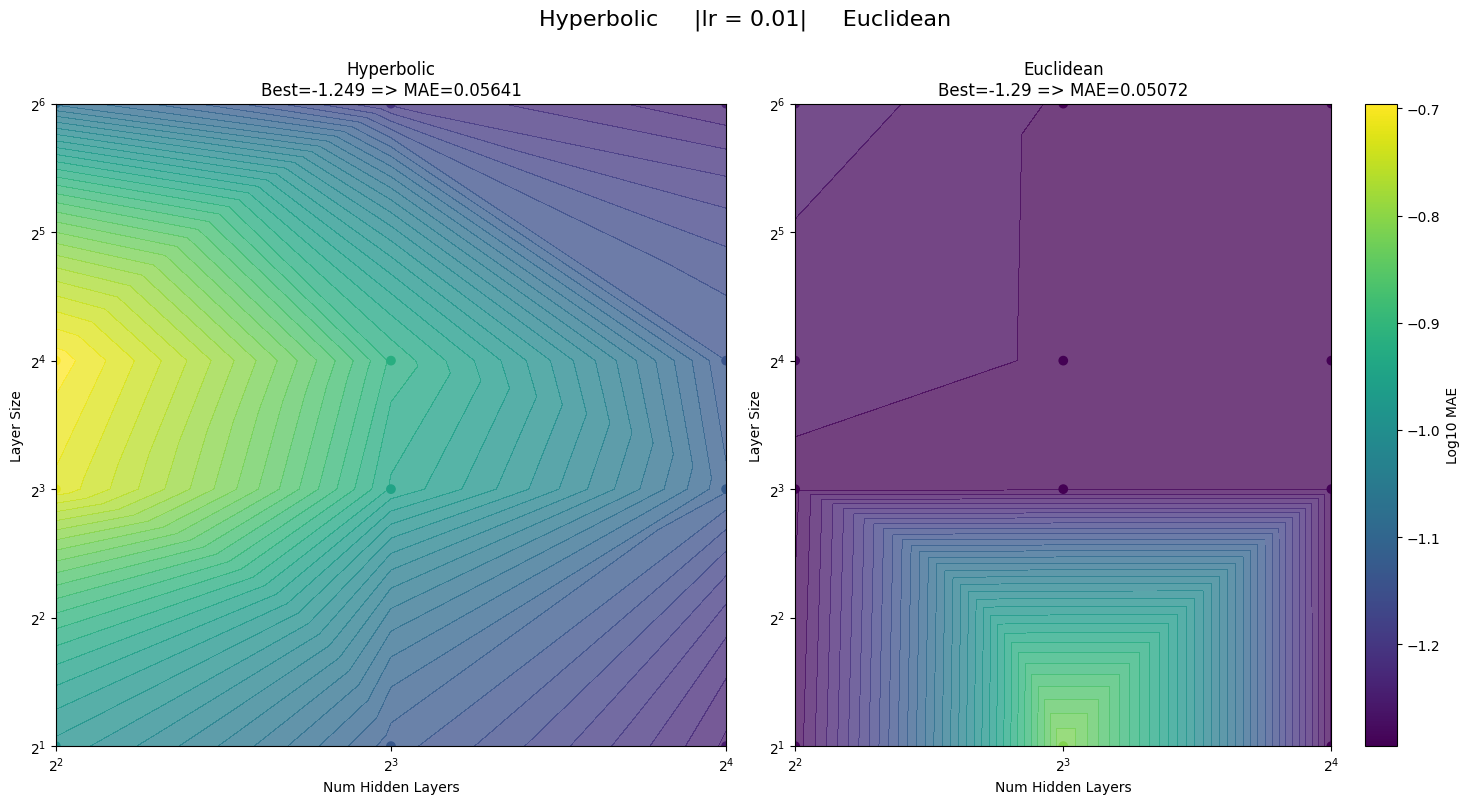

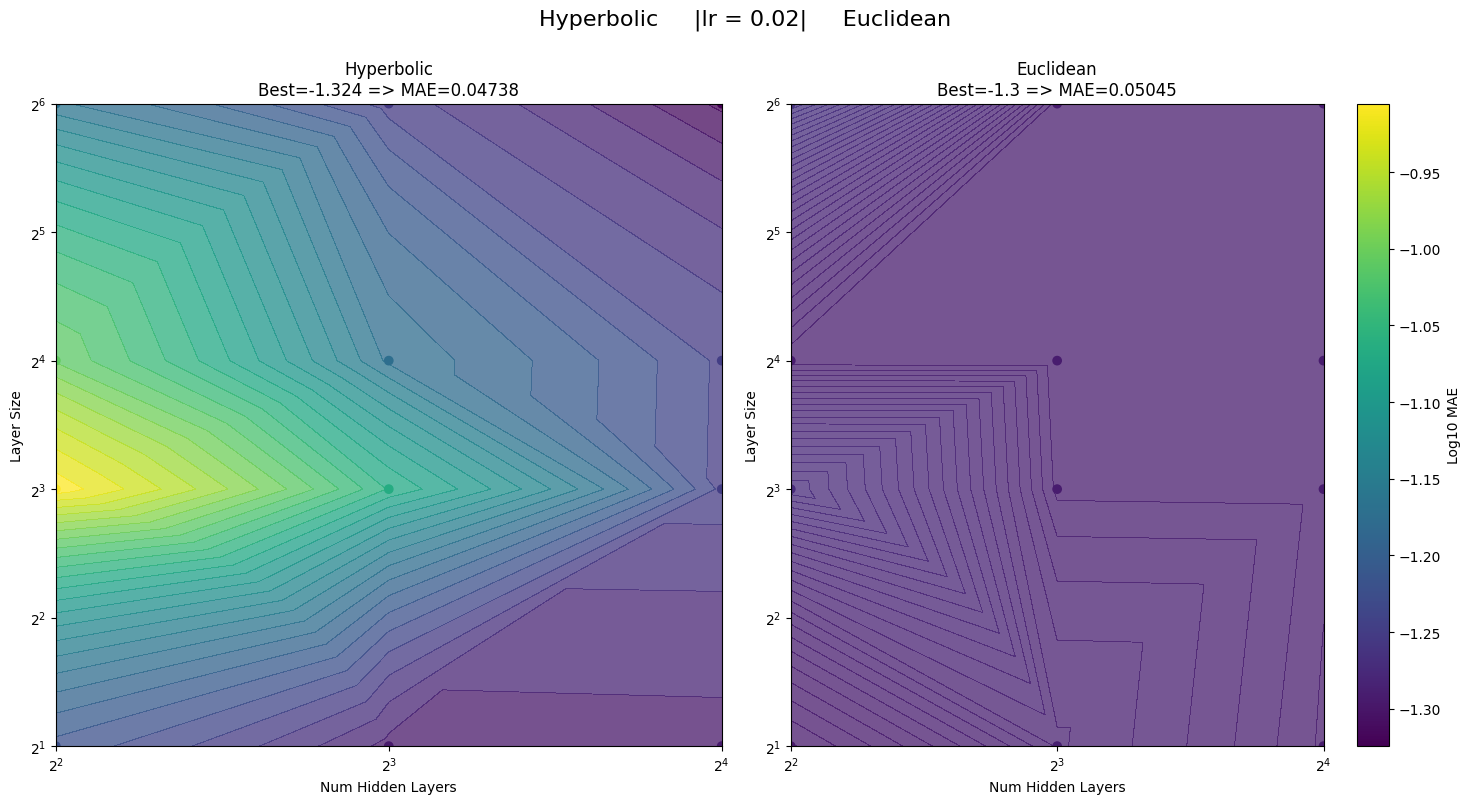

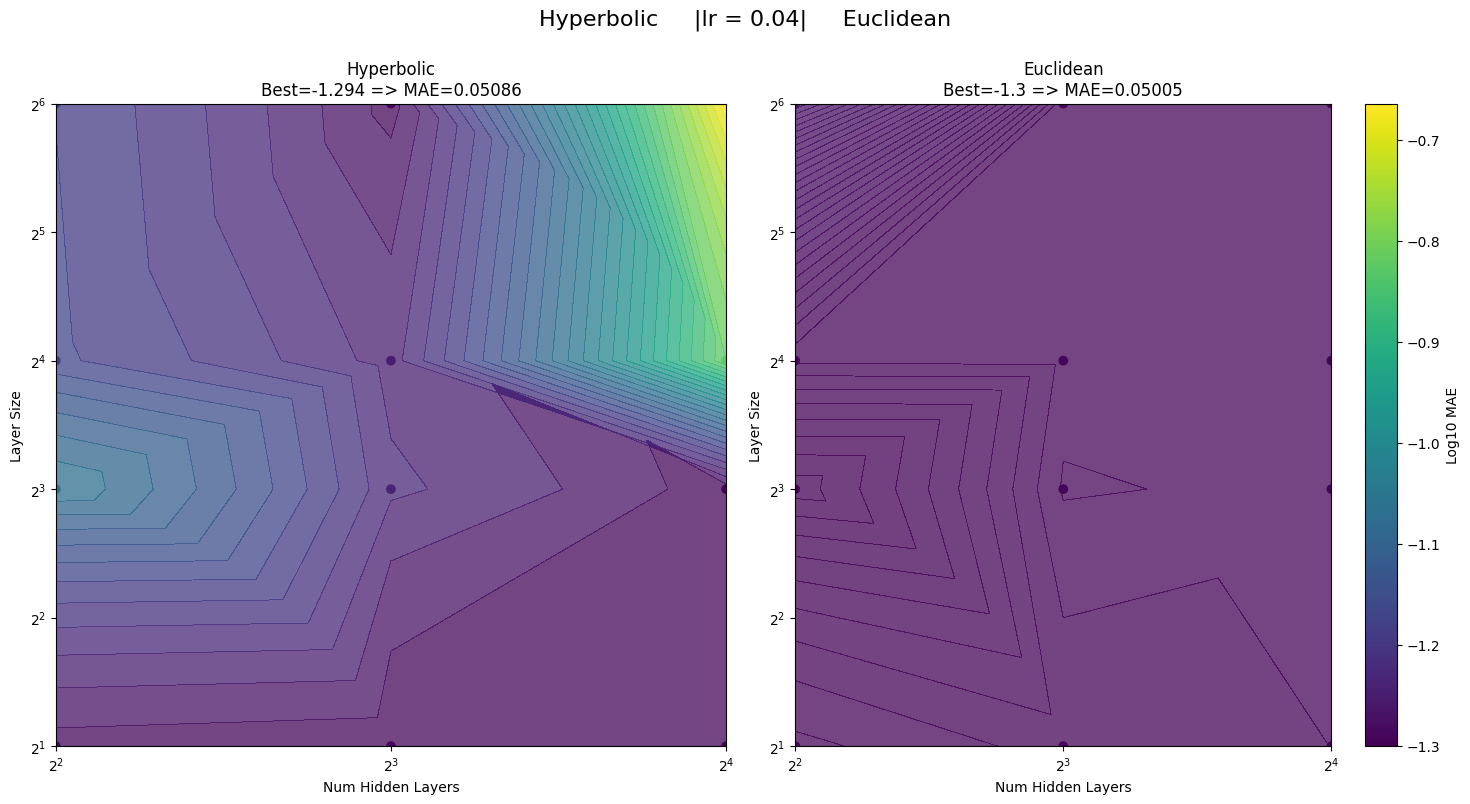

--------------- Weight Decay: 0.005 ---------------


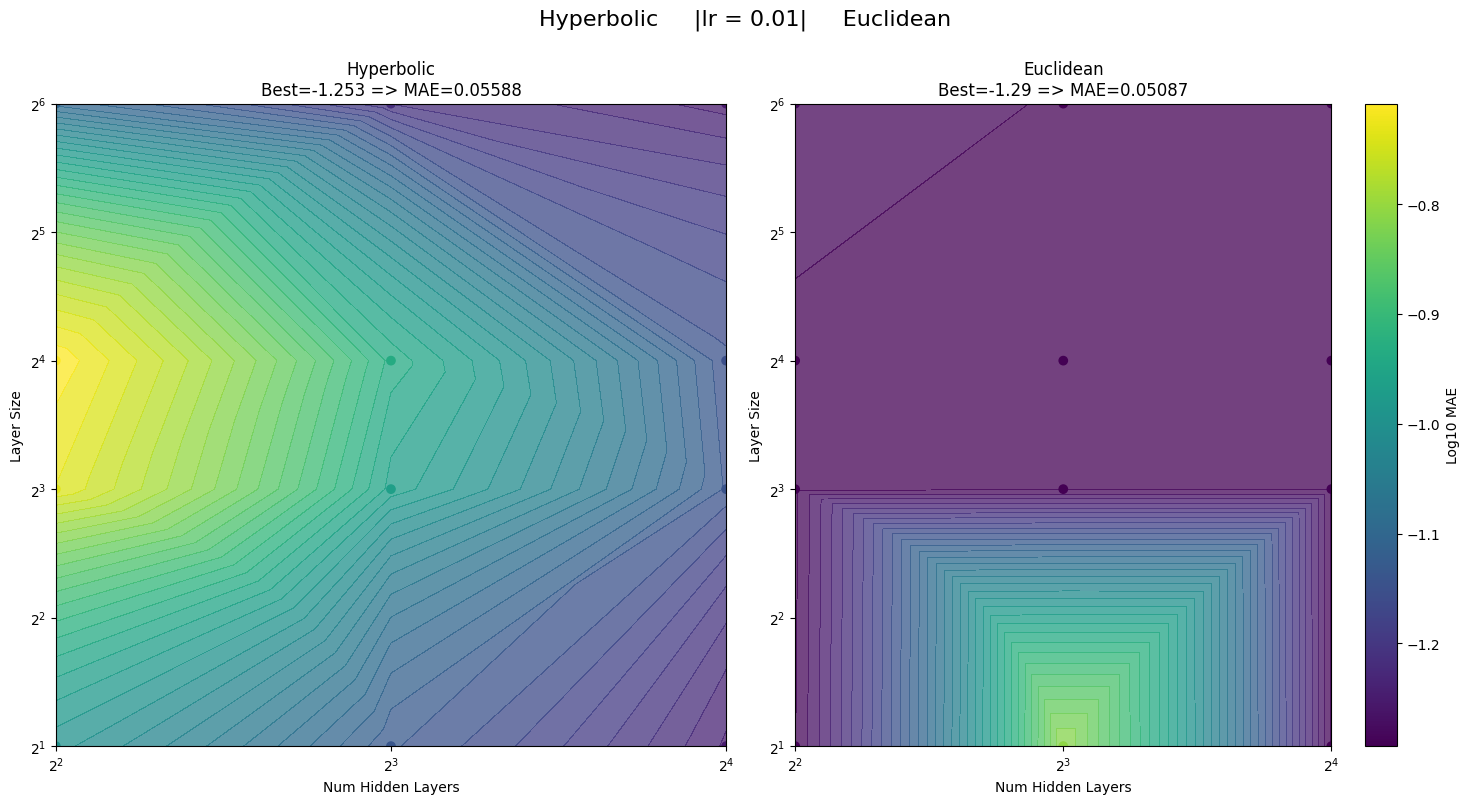

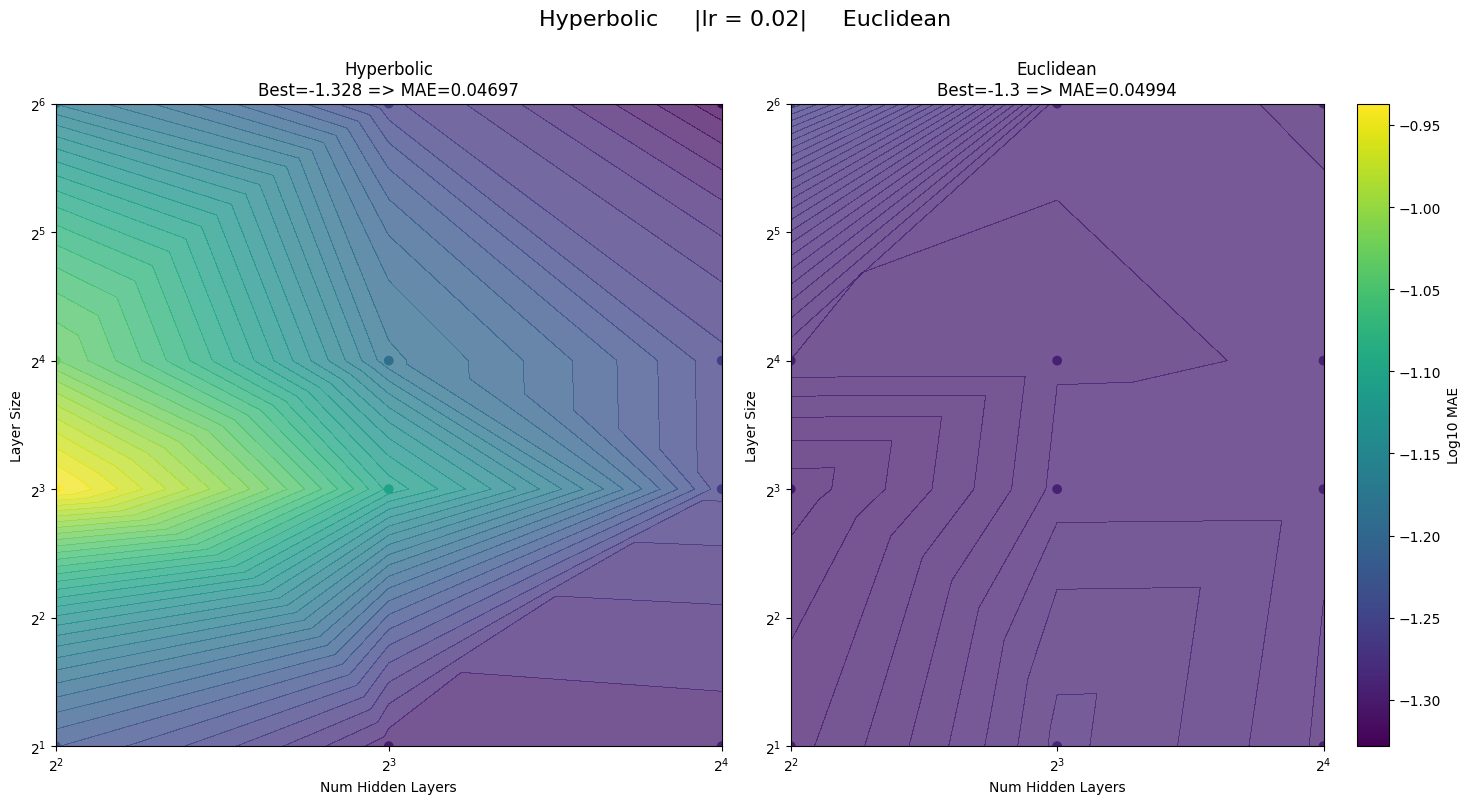

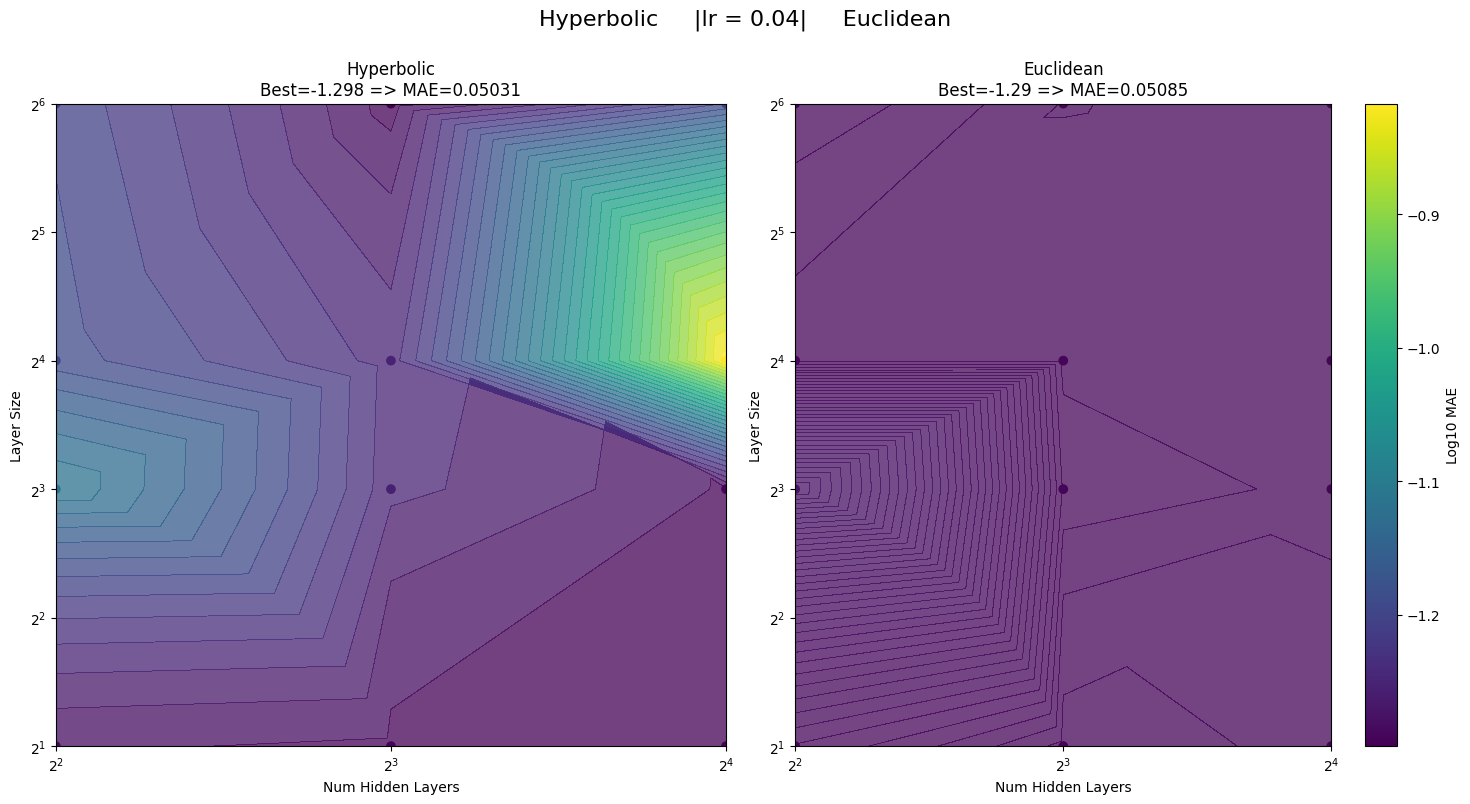

In [25]:
for i, wd in enumerate(WD):
    print(f'--------------- Weight Decay: {wd} ---------------')
    hyp_values_wd = hyp_values[i::len(WD)]
    euc_values_wd = euc_values[i::len(WD)]
    for i, lr in enumerate(LR):
        hyp_data = np.log10(hyp_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i])
        euc_data = np.log10(euc_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i])

        min_val = min(np.min(hyp_data), np.min(euc_data))
        max_val = max(np.max(hyp_data), np.max(euc_data))

        cmap = plt.cm.viridis
        norm = Normalize(vmin=min_val, vmax=max_val)


        num_hidden_layers_adjust = num_hidden_layers.astype(float)
        num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

        mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


        plt.figure(figsize=(15,8))
        plt.suptitle(f'Hyperbolic     |lr = {lr}|     Euclidean', fontsize=16, y=1)

        plt.subplot(121)
        plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

        plt.title(f'Hyperbolic\nBest={np.min(hyp_data):.3f} => MAE={np.power(10, np.min(hyp_data)):.5f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)


        plt.subplot(122)
        euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
        plt.colorbar(euc_scatter, label='Log10 MAE')


        plt.title(f'Euclidean\nBest={np.min(euc_data):.3} => MAE={np.power(10, np.min(euc_data)):.5f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)

        plt.tight_layout()
        plt.show()

<h3>Best Runs:</h3>
<!-- Checked every 100 epochs, bc taking the min epoch gives advantage to unstable training.

Hyperbolic:  MAE = 0.035 (100 EPOCHS)
- num-l:  4
- size-l: 64
- lr: 0.016
- wd: 0.008

Hyperbolic:  MAE = 0.034 (100 EPOCHS)
- num-l:  4
- size-l: 64
- lr: 0.015
- wd: 0.004

Hyperbolic:  MAE = 0.033 (100 EPOCHS)
- num-l:  4
- size-l: 32
- lr: 0.02
- wd: 0.006

Euclidean: MAE = 0.040 (100 EPOCHS)
- num-l:  4
- size-l: 512
- lr: 0.016
- wd: 0.004

Euclidean: MAE = 0.037 (100 EPOCHS)
- num-l:  4
- size-l: 320
- lr: 0.02
- wd: 0.004 
-->

<h2>Take subsets of normal cross-val train-indices, average over 5 seeds</h2>
<h3>Hyp run for 99 epochs, Euc run for 49 epochs.</h3>
 
<h3>1</h3>

- Hyp: 0.031; 16,64; 0.01,0.003 
- Euc: 0.036; 4,8;  0.01,0.003

<h3>1/2</h3>

- Hyp: 0.038; 4,64; 0.04,0.004
- Euc: 0.039; 4,8;  0.01,0.003

<h3>1/3</h3>

- Hyp: 0.040; 8,64; 0.02,0.005
- Euc: 0.043; 4,8; 0.02,0.003

<h3>1/4</h3>

- Hyp: 0.042; 4,64; 0.04,0.004
- Euc: 0.045, 4,2; 0.02,0.004

<h3>1/6</h3>

- Hyp: 0.043; 8,64; 0.02,0.003
- Euc: 0.047; 4,2; 0.02,0.004

<h3>1/8</h3>

- Hyp: 0.047; 16,64; 0.02,0.005
- Euc: 0.050; 4,2; 0.02,0.003

In [29]:
K = 99

best_hyp_params = np.argsort(hyp_values.mean(axis=1)[:,K])[:10]
print(hyp_values.mean(axis=1)[:,K][best_hyp_params])
print()
best_euc_params = np.argsort(euc_values.mean(axis=1)[:,K])[:10]
print(euc_values.mean(axis=1)[:,K][best_euc_params])

best_hyp_runs = hyp_values.mean(axis=1)[best_hyp_params]
best_euc_runs = euc_values.mean(axis=1)[best_euc_params]

[0.04697021 0.04737799 0.04783004 0.05030665 0.05049377 0.05052985
 0.05065169 0.05074518 0.05076013 0.05078145]

[0.04994456 0.05005145 0.05012193 0.05033333 0.05044864 0.05072026
 0.05085485 0.05086673 0.05087125 0.05087863]


In [27]:
print(hyp_params[best_hyp_params])
print()
print(euc_params[best_euc_params])

[{'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 16, 'layer_size': 64, 'lr': 0.02, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 16, 'layer_size': 64, 'lr': 0.02, 'weight_decay': 0.004, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 16, 'layer_size': 64, 'lr': 0.02, 'weight_decay': 0.003, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 8, 'layer_size': 64, 'lr': 0.04, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 0, 'model_type': 'hyp', 'num_hidden_layers': 16, 'layer_size': 8, 'lr': 0.04, 'weight_decay': 0.003, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed'

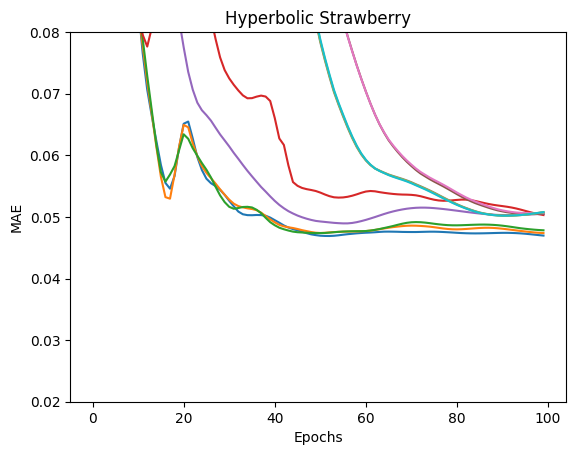

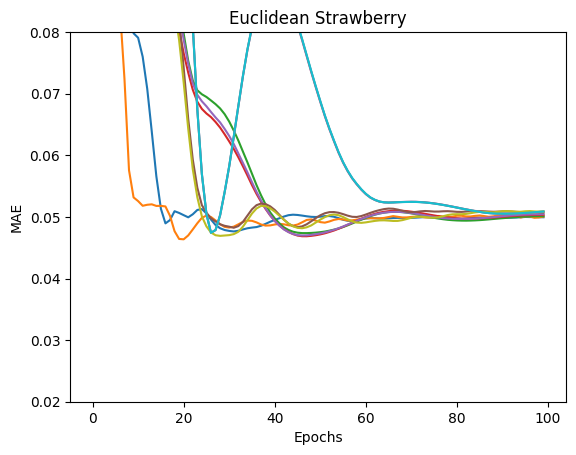

In [190]:
for run in hyp_values.mean(axis=1)[best_hyp_params]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Hyperbolic Strawberry')
plt.ylabel('MAE')
plt.xlabel('Epochs')

plt.ylim(0.02,0.08)
# plt.yscale('log')
plt.show()

for run in euc_values.mean(axis=1)[best_euc_params]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Euclidean Strawberry')
plt.ylabel('MAE')
plt.xlabel('Epochs')

plt.ylim(0.02,0.08)
# plt.yscale('log')
plt.show()
